<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone

# Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Models and metrics
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_pinball_loss, make_scorer
from sklearn.model_selection import ParameterGrid

from itertools import combinations
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

### Load Data

Entao, em vez de usarmos o que foi feito na part 1 vamos correr a pipeline para todo e obter o X_train, test e o validation

In [2]:
#Load Dic
brand_model_dic = pd.read_parquet("./project_data/brand_model_dic.parquet", engine="pyarrow")

# Load the processed datasets (train, validation, test)
X_train = pd.read_parquet("./project_data/X_train.parquet", engine="pyarrow")
X_val   = pd.read_parquet("./project_data/X_val.parquet",   engine="pyarrow")
X_test  = pd.read_parquet("./project_data/X_test.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

In [3]:
from preprocessing_pipeline import CarPreprocessingPipeline

# Correções manuais
manual_model_corrections = {
    'val': {'w123': 'e class', 'veloster': 'i30', 's5': 'a5', 'a2': 'a1'},
    'test': {'veloster': 'i30', 's5': 'a5', 'r class': 'gl class', 
             'amica': 'i10', 'rs7': 'rs6', 'i4': '3 series', 
             'transit courier': 'tourneo connect', '190': 'c class'}
}

# FIT e TRANSFORM
pipeline = CarPreprocessingPipeline(reference_year=2020)
pipeline.fit(X_train, y_train, brand_model_dic, manual_model_corrections=manual_model_corrections)

X_train_original = pipeline.transform(X_train, dataset_name="train")
X_val_original = pipeline.transform(X_val, dataset_name="val")
X_test_original = pipeline.transform(X_test, dataset_name="test")

# SAVE
#X_train_final.reset_index().to_parquet("./project_data/X_train_processed.parquet", index=False)
#X_val_final.reset_index().to_parquet("./project_data/X_val_processed.parquet", index=False)
#X_test_final.reset_index().to_parquet("./project_data/X_test_processed.parquet", index=False)
#pipeline.save("./project_data/car_pipeline_fitted.joblib")


[1/13] Preparando dicionário de referência...
[2/13] Normalizando Brand e model...
[3/13] Limpando Brand e model...
[4/13] Imputando models por engineSize...
[5/13] Forçando missing para needs_review...
[6/13] Limpando variáveis numéricas e categóricas...
[7/13] Calculando modas para imputação MCAR (model por Brand)...
[8/13] Identificando variáveis MAR...
[9/13] Fitting MICE imputer...
[10/13] Calculando tabela de modelos frequentes...
[11/13] Calculando parâmetros de feature engineering...


\\wsl.localhost\Ubuntu\home\mpais-go\ML_project\preprocessing_pipeline.py:718: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  keep_mask = X["keep"].fillna(False)


[12/13] Fitting encoders...
[13/13] Fitting final scaler...

✓ Pipeline fitted! Final shape: (60769, 38)
  Features: 38
  ✓ X_train transformado guardado internamente (use get_transformed_train())

TRANSFORMANDO TRAIN (60769 rows)

[1/11] Normalizando Brand e model...
[2/11] Limpando Brand e model...
[3/11] Imputando models por engineSize...
[4/11] Aplicando correções manuais...
[5/11] Limpando variáveis numéricas e categóricas...
[6/11] Imputando Brand e model (MCAR condicional)...
[7/11] Criando flags de missing...
[8/11] Aplicando MICE imputation...
[9/11] Colapsando modelos raros...


\\wsl.localhost\Ubuntu\home\mpais-go\ML_project\preprocessing_pipeline.py:718: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  keep_mask = X["keep"].fillna(False)


[10/11] Criando features...
[11/11] Aplicando encoding e scaling final...

✓ Transformação concluída! Shape final: (60769, 38)

TRANSFORMANDO VAL (15193 rows)

[1/11] Normalizando Brand e model...
[2/11] Limpando Brand e model...
[3/11] Imputando models por engineSize...
[4/11] Aplicando correções manuais...
[5/11] Limpando variáveis numéricas e categóricas...
[6/11] Imputando Brand e model (MCAR condicional)...
[7/11] Criando flags de missing...
[8/11] Aplicando MICE imputation...
[9/11] Colapsando modelos raros...
[10/11] Criando features...
[11/11] Aplicando encoding e scaling final...


\\wsl.localhost\Ubuntu\home\mpais-go\ML_project\preprocessing_pipeline.py:718: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  keep_mask = X["keep"].fillna(False)



✓ Transformação concluída! Shape final: (15193, 38)

TRANSFORMANDO TEST (32567 rows)

[1/11] Normalizando Brand e model...
[2/11] Limpando Brand e model...
[3/11] Imputando models por engineSize...
[4/11] Aplicando correções manuais...
[5/11] Limpando variáveis numéricas e categóricas...
[6/11] Imputando Brand e model (MCAR condicional)...
[7/11] Criando flags de missing...
[8/11] Aplicando MICE imputation...
[9/11] Colapsando modelos raros...
[10/11] Criando features...
[11/11] Aplicando encoding e scaling final...


\\wsl.localhost\Ubuntu\home\mpais-go\ML_project\preprocessing_pipeline.py:718: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  keep_mask = X["keep"].fillna(False)



✓ Transformação concluída! Shape final: (32567, 38)


In [33]:
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

In [34]:
X_train_original.columns

Index(['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'mpg_is_missing', 'tax_is_missing',
       'engineSize_is_missing', 'year_is_missing', 'brand_mean_price',
       'brand_median_price', 'brand_price_std', 'brand_count', 'age',
       'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage',
       'low_mileage', 'age_mileage_interaction',
       'premium_brand_engine_size_interaction', 'tax_per_engine',
       'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc',
       'transmission_manual', 'transmission_other', 'transmission_semi auto',
       'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid',
       'fuelType_other', 'fuelType_petrol', 'fuelType_unknown',
       'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

In [35]:
#Utils
#Plots the error curve (MAE) for Train and Validation in Wrapper methods (RFE/SFS)
def plot_rfe_sfs_scores(train_scores, val_scores, optimal_n, model_name, method_name):
    nof_list = np.arange(1, len(train_scores) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(nof_list, train_scores, label=f"MAE Train ({model_name})", color=palette[4])
    plt.plot(nof_list, val_scores, label=f"MAE Validation ({model_name})", color=palette[0])
    
    # Add vertical line at optimal point
    plt.axvline(x=optimal_n, color='red', linestyle='--', label=f'Optimal (n={optimal_n})')
    
    plt.xlabel("NNumber of Features")
    plt.ylabel("MAE (Mean Absolute Error)")
    plt.title(f"{method_name} - Optimization of MAE vs. Number of Features ({model_name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [36]:
#Utils
#Plots feature importance for embedding methods (top 20)
def plot_importance_unified(importance_series, name, is_tree_model=False):
    # Select the top 20 most important features
    imp_coef = importance_series.sort_values(ascending=False).head(20)
    
    color = palette[1] if is_tree_model else palette[0]
    plt.figure(figsize=(9, 6))
    imp_coef.sort_values().plot(kind="barh", color=color) 
    
    plt.title("Feature Importance using " + name + " Model (Top 20)", fontsize=15)
    plt.xlabel("Magnitude of Coefficient / Gini Importance")
    plt.show()

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods - Single Variable</b></span>
    </h1>
</div>

##### **Variance Threshold**

In [37]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train_original)

# Get low variance columns and print them
low_variance = X_train_original.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train_original.columns.get_loc(col)]:.4f}")

Number of features with variance closer to zero: 1
Features with variance closer to zero:
hasDamage: 0.0000


In [38]:
# Drop low variance columns from train, val and test sets
X_train = X_train_original.drop(columns=low_variance, errors='ignore')
X_val = X_val_original.drop(columns=low_variance, errors='ignore')
X_test = X_test_original.drop(columns=low_variance, errors='ignore')

In [39]:
# ID - a excluir das análises
id_column = ['carID']

# Binary variables (0/1) - flags e one-hot encoded
bin_variables = [
    # Missing flags
    'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing',
    # Car age flags
    'is_new_car', 'is_old_car',
    # Mileage flags
    'high_mileage', 'low_mileage',
    # Transmission (OHE)
    'transmission_manual', 'transmission_other', 'transmission_semi auto', 'transmission_unknown',
    # Fuel Type (OHE)
    'fuelType_electric', 'fuelType_hybrid', 'fuelType_other', 'fuelType_petrol', 'fuelType_unknown',
    # Brand segment (OHE)
    'brand_segment_luxury', 'brand_segment_mid_range'
]

# Target encoded variables (high cardinality)
target_encoded_variables = ['Brand_target_enc', 'brand_model_target_enc']

# Numerical variables (continuous)
numerical_variables = [
    # Original features
    'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners',
    # Brand statistics
    'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count',
    # Derived features
    'age', 'miles_per_year',
    # Interactions
    'age_mileage_interaction', 'premium_brand_engine_size_interaction',
    'tax_per_engine', 'mpg_per_liter'
]

In [40]:
y_train = y_train.set_index('carID')
y_val = y_val.set_index('carID')

y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]

##### **Correlation Indices with price**

In [41]:
# Correlação de cada feature com o target (price)
cor_with_target = pd.concat([X_train, y_train], axis=1).corr(method='spearman')['price'].drop('price')

# Criar DataFrame ordenado por valor absoluto
cor_df = pd.DataFrame({
    'Feature': cor_with_target.index,
    'Correlation': cor_with_target.values,
    'Abs_Correlation': np.abs(cor_with_target.values)
}).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Mostrar
print("=== Correlation with Price (Spearman) ===")
display(cor_df)

# Destacar features com baixa correlação (|corr| < 0.1)
low_corr = cor_df[cor_df['Abs_Correlation'] < 0.1]
print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")
display(low_corr)

<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_4140\329786757.py:17: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")


=== Correlation with Price (Spearman) ===


,Feature,Correlation,Abs_Correlation
0,brand_model_target_enc,0.763932,0.763932
1,mpg_per_liter,-0.602180,0.602180
2,age,-0.595536,0.595536
3,transmission_manual,-0.579807,0.579807
4,Brand_target_enc,0.579663,0.579663
5,brand_mean_price,0.579663,0.579663
6,brand_median_price,0.579663,0.579663
7,age_mileage_interaction,-0.571321,0.571321
8,engineSize,0.562088,0.562088
9,brand_price_std,0.546905,0.546905


\ Features with |corr| < 0.1 (15):


,Feature,Correlation,Abs_Correlation
22,fuelType_hybrid,0.073971,0.073971
23,mpg_is_missing,0.051764,0.051764
24,tax_is_missing,0.050276,0.050276
25,brand_segment_mid_range,-0.048547,0.048547
26,tax_per_engine,-0.033406,0.033406
27,brand_count,-0.015177,0.015177
28,fuelType_other,0.007272,0.007272
29,engineSize_is_missing,-0.004468,0.004468
30,transmission_other,0.004114,0.004114
31,year_is_missing,0.003740,0.003740


##### **Statistical Hypothesis Testing - ANOVA** 

In [42]:
bin_cols = [c for c in X_train.columns if X_train[c].dropna().nunique() == 2]

X_train_cat = X_train
for c in bin_cols:
    X_train_cat[c] = X_train[c].astype('category')

alpha = 0.05

ANOVA_COLS = X_train_cat.columns.tolist() 

anova_results = []
y_price = y_price = y_train['price'].copy()

for col in ANOVA_COLS:
    # Prepare data for ANOVA test
    temp_df = pd.DataFrame({'category': X_train_cat[col], 'price': y_price}).dropna()
    
    # Get price lists for each category
    # If the column has few categories, use all
    groups = [temp_df['price'][temp_df['category'] == category] 
              for category in temp_df['category'].unique()]
    
    # Execute the ANOVA Test
    if len(groups) > 1 and all(len(g) > 0 for g in groups):
        f_stat, p_value = f_oneway(*groups)
        
        #if p < alpha, reject H0 (group means are different) which means the variable is PREDICTIVE
        decision = "predictive" if p_value < alpha else "NOT predictive"
        
        # Calculate mean prices per category
        mean_prices = temp_df.groupby('category')['price'].mean().round(2).to_dict()
    else:
        f_stat, p_value = np.nan, np.nan
        decision = "single group"
        mean_prices = {}

    anova_results.append({
        "Variable": col,
        "Test": "ANOVA",
        "F_Stat": f_stat,
        "p_value": p_value,
        "Decision": decision,
        "Group_Means": mean_prices
    })

# Convert to DataFrame for easy visualization
df_anova = pd.DataFrame(anova_results).sort_values('p_value', na_position='last').reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_anova)
pd.reset_option('display.max_rows')

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_4140\2100398087.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = temp_df.groupby('category')['price'].mean().round(2).to_dict()


,Variable,Test,F_Stat,p_value,Decision,Group_Means
0,tax,ANOVA,2.814614,0.000000e+00,predictive,"{-2.436477280520981: 30494.0, -2.0983295439784..."
1,mpg,ANOVA,7.227624,0.000000e+00,predictive,"{-33.127637130863896: 28990.0, -7.667246876415..."
2,engineSize,ANOVA,42.504851,0.000000e+00,predictive,"{-14.114252060766008: 19490.0, -14.01367466594..."
3,age,ANOVA,1049.972631,0.000000e+00,predictive,"{-2.2198436116602633: 27287.78, -1.00930292101..."
4,brand_price_std,ANOVA,3114.073656,0.000000e+00,predictive,"{-1.5453357804686054: 10379.63, -0.90954438750..."
5,brand_count,ANOVA,3114.073656,0.000000e+00,predictive,"{-1.892158136257373: 12864.32, -1.566772680704..."
6,brand_mean_price,ANOVA,3114.073656,0.000000e+00,predictive,"{-1.4915850703846387: 10379.63, -0.81894571597..."
7,brand_median_price,ANOVA,3114.073656,0.000000e+00,predictive,"{-1.3968544349551593: 10379.63, -1.15956590067..."
8,is_new_car,ANOVA,20517.846354,0.000000e+00,predictive,"{-0.6801111256265131: 13548.04, 1.470347950974..."
9,brand_model_target_enc,ANOVA,643.251878,0.000000e+00,predictive,"{-5.668325578896322: 2027.5, -2.89808511302853..."


<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.2 |  Wrapper Methods</b></span>
    </h1>
</div>

##### **RFE**

We applied **RFE (Recursive Feature Elimination)** based on the class example but extended it to work with both **Linear Regression** and **Random Forest** models, using **MAE** as the optimization criterion. The procedure iteratively removes the least important features, retraining the model each time to identify the subset of features that minimizes validation error. This approach allows us to balance model simplicity and predictive performance, ensuring that only the most relevant predictors are retained.


In [43]:
def plot_rfe_scores(train_scores, val_scores, optimal_n, model_name):
    nof_list = np.arange(1, len(train_scores) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(nof_list, train_scores, label=f"MAE Train ({model_name})", color=palette[4])
    
    #vertical line at the optimal point
    plt.axvline(x=optimal_n, color='red', linestyle='--', label=f'Optimal (n={optimal_n})')
    
    plt.xlabel("Number of Features")
    plt.ylabel("MAE (Mean Absolute Error)")
    plt.title(f"RFE - Optimization of Number of Features ({model_name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [44]:
def find_optimal_features_rfe(model, X_train, y_train, X_val, y_val):
    nof_list = np.arange(1, len(X_train.columns) + 1)
    low_score = float('inf')  # Start with an infinite value to find the minimum
    nof = 0
    train_score_list = []
    val_score_list = []

    print(f"Running RFE with model: {model.__class__.__name__}")

    for n in nof_list:
        # Use clone to ensure the model is "clean" in each iteration
        estimator = clone(model)
        
        rfe = RFE(estimator=estimator, n_features_to_select=n)
        X_train_rfe = rfe.fit_transform(X_train, y_train)
        X_val_rfe = rfe.transform(X_val)

        # Train the final model with the selected features
        estimator.fit(X_train_rfe, y_train)
        
        # Store the MAE scores
        train_pred = estimator.predict(X_train_rfe)
        train_mae = mean_absolute_error(y_train, train_pred)
        train_score_list.append(train_mae)
        
        val_pred = estimator.predict(X_val_rfe)
        val_mae = mean_absolute_error(y_val, val_pred)
        val_score_list.append(val_mae)

        # Check for the lowest validation error
        if val_mae <= low_score:
            low_score = val_mae
            nof = n

    print(f"Optimal number of features: {nof} with a validation MAE of {low_score:.4f}")

    # Train the final model with the optimal number of features to get the final feature list
    final_rfe = RFE(estimator=clone(model), n_features_to_select=nof)
    final_rfe.fit(X_train, y_train)
    selected_features_names = X_train.columns[final_rfe.support_].tolist()

    # Return all useful results
    return {
        'optimal_n': nof,
        'best_score': low_score,
        'selected_features': selected_features_names,
        'train_scores': train_score_list,
        'val_scores': val_score_list
    }

Running RFE with model: LinearRegression
Optimal number of features: 13 with a validation MAE of 2889.4063
LR Features (13): ['mileage', 'mpg', 'engineSize', 'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count', 'age', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc', 'brand_segment_mid_range']



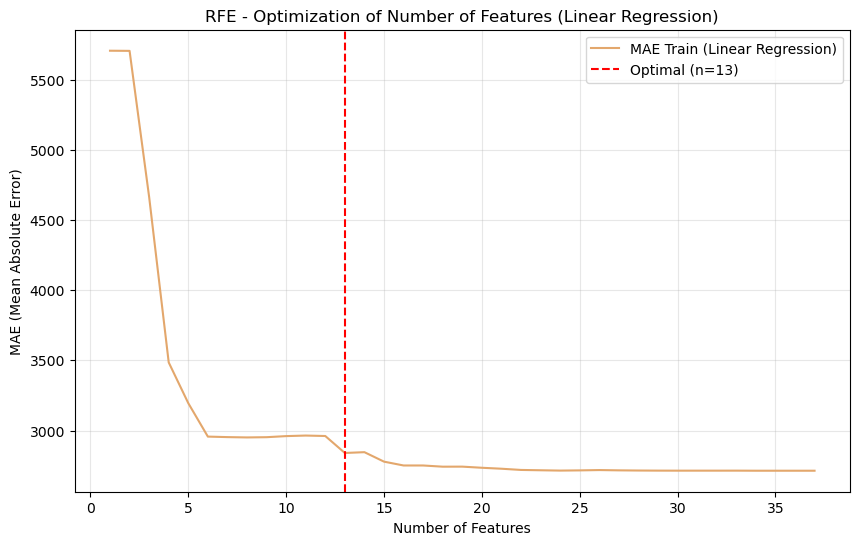

Running RFE with model: DecisionTreeRegressor
Optimal number of features: 11 with a validation MAE of 1775.9637
RF Features (11): ['mileage', 'mpg', 'engineSize', 'brand_count', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'brand_model_target_enc', 'transmission_manual']


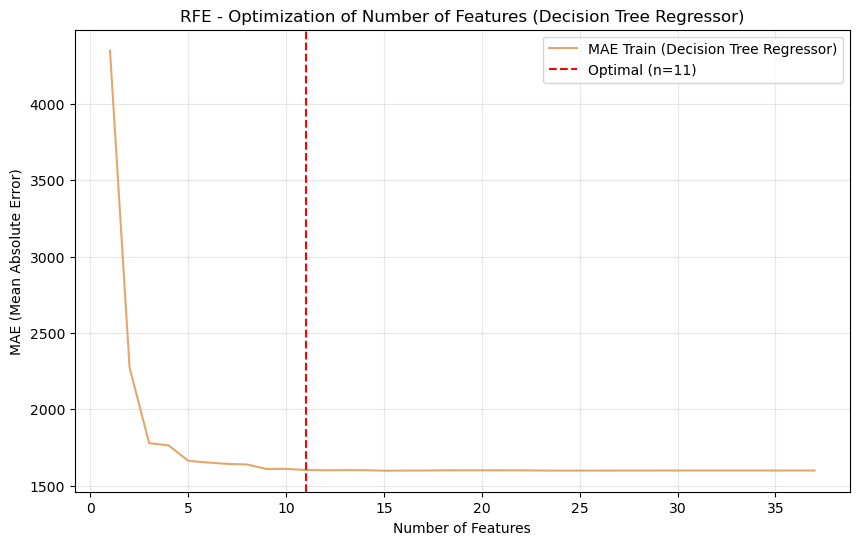

In [45]:
# RFE with Linear Regression optimized for MAE
lr_model = LinearRegression()
rfe_results_lr = find_optimal_features_rfe(lr_model, X_train, y_train, X_val, y_val)
print(f"LR Features ({rfe_results_lr['optimal_n']}): {rfe_results_lr['selected_features']}\n")
plot_rfe_scores(rfe_results_lr['train_scores'], rfe_results_lr['val_scores'], rfe_results_lr['optimal_n'], 'Linear Regression')

# RFE com Decision Tree Regressor optimized for MAE
dt_model = DecisionTreeRegressor(max_depth=10, random_state=37)
rfe_results_dt = find_optimal_features_rfe(dt_model, X_train, y_train, X_val, y_val)
print(f"RF Features ({rfe_results_dt['optimal_n']}): {rfe_results_dt['selected_features']}")
plot_rfe_scores(rfe_results_dt['train_scores'], rfe_results_dt['val_scores'], rfe_results_dt['optimal_n'], 'Decision Tree Regressor')

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.3 |  Embedded Methods</b></span>
    </h1>
</div>

In [46]:
from sklearn.feature_selection import SelectFromModel

# Função auxiliar para imprimir e selecionar (evita repetição)
def print_selection_results(importance_series, model_name, selection_method="nonzero"):
    """
    selection_method: 
      - 'nonzero': Para Lasso (seleciona tudo o que não é 0)
      - 'mean': Para Ridge/Trees (seleciona tudo acima da média de importância)
    """
    if selection_method == "nonzero":
        # Para Lasso: seleciona se diferente de zero
        selected_feats = importance_series[importance_series != 0].index.tolist()
        criteria_msg = "Coefficient != 0"
    else:
        # Para Ridge e Árvores: seleciona se acima da média
        threshold = importance_series.mean()
        selected_feats = importance_series[importance_series > threshold].index.tolist()
        criteria_msg = f"Importance > Mean ({threshold:.4f})"

    print(f"\n" + "-"*60)
    print(f"MODEL: {model_name}")
    print(f"Selection Criteria: {criteria_msg}")
    print(f"Number of features selected: {len(selected_feats)}")
    print(f"Selected Features: {selected_feats}")
    print("-"*60 + "\n")


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e+09, tolerance: 5.758e+08
  model = cd_fast.enet_coordinate_descent(


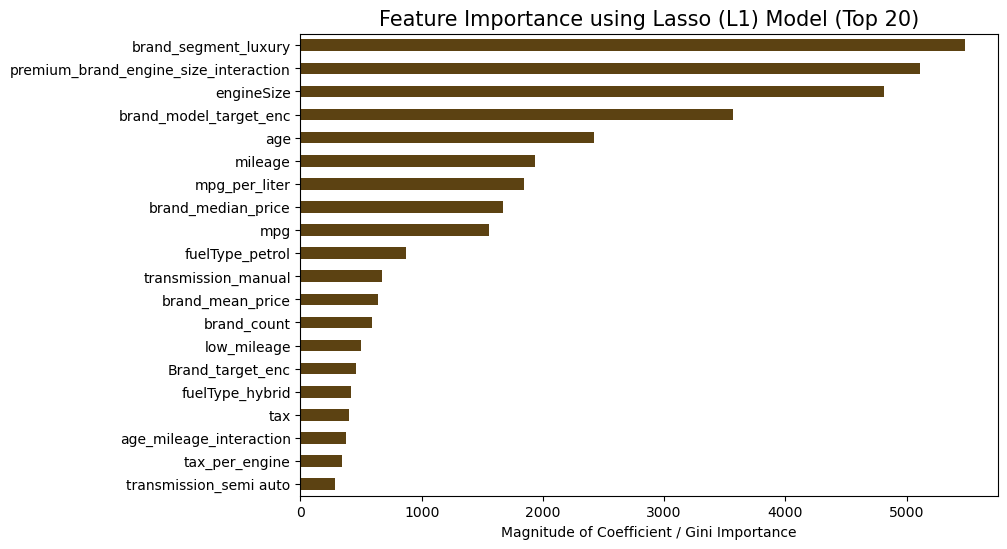


------------------------------------------------------------
MODEL: Lasso (L1)
Selection Criteria: Coefficient != 0
Number of features selected: 37
Selected Features: ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count', 'age', 'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage', 'low_mileage', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc', 'transmission_manual', 'transmission_other', 'transmission_semi auto', 'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid', 'fuelType_other', 'fuelType_petrol', 'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range']
------------------------------------------------------------



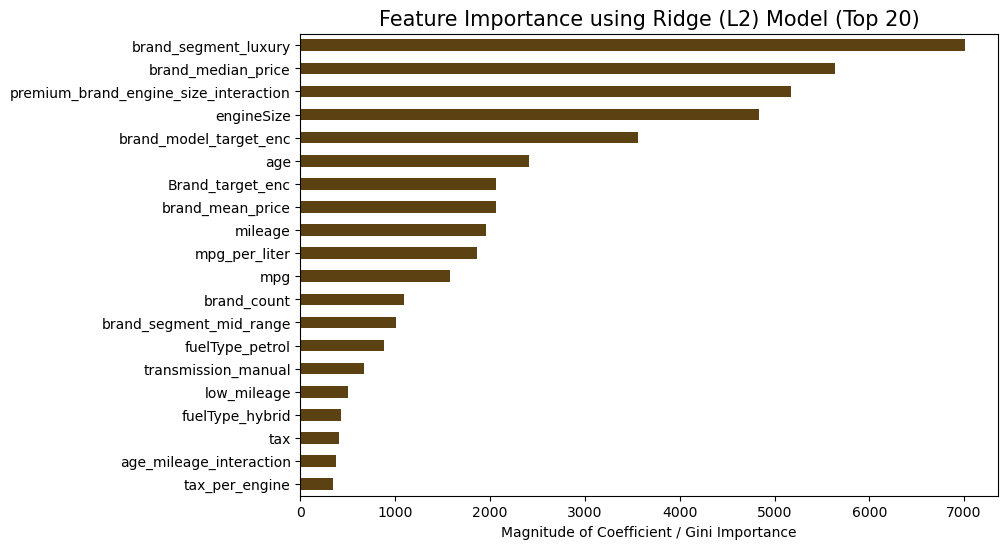


------------------------------------------------------------
MODEL: Ridge (L2)
Selection Criteria: Importance > Mean (1227.7559)
Number of features selected: 11
Selected Features: ['mileage', 'mpg', 'engineSize', 'brand_mean_price', 'brand_median_price', 'age', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc', 'brand_segment_luxury']
------------------------------------------------------------



c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


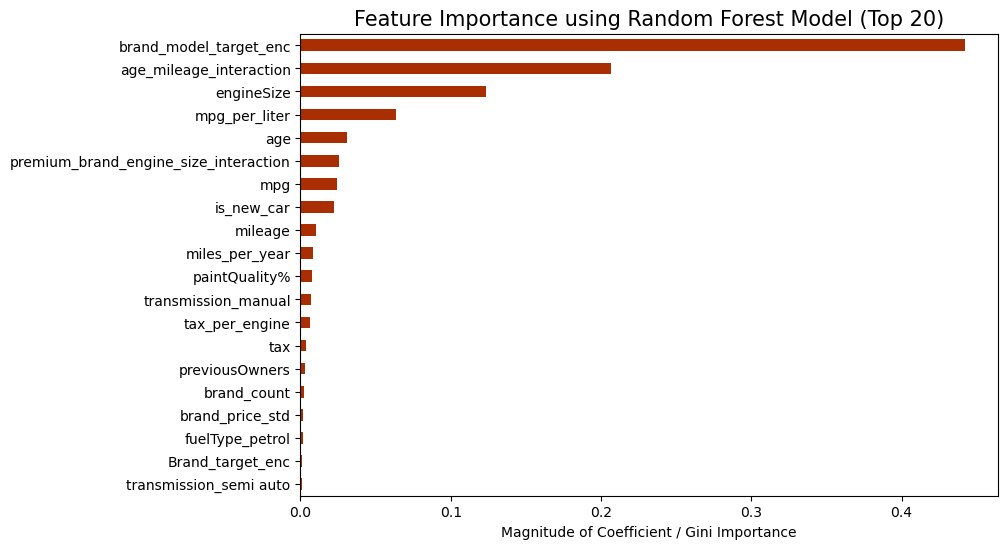


------------------------------------------------------------
MODEL: Random Forest
Selection Criteria: Importance > Mean (0.0270)
Number of features selected: 5
Selected Features: ['engineSize', 'age', 'age_mileage_interaction', 'mpg_per_liter', 'brand_model_target_enc']
------------------------------------------------------------



c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


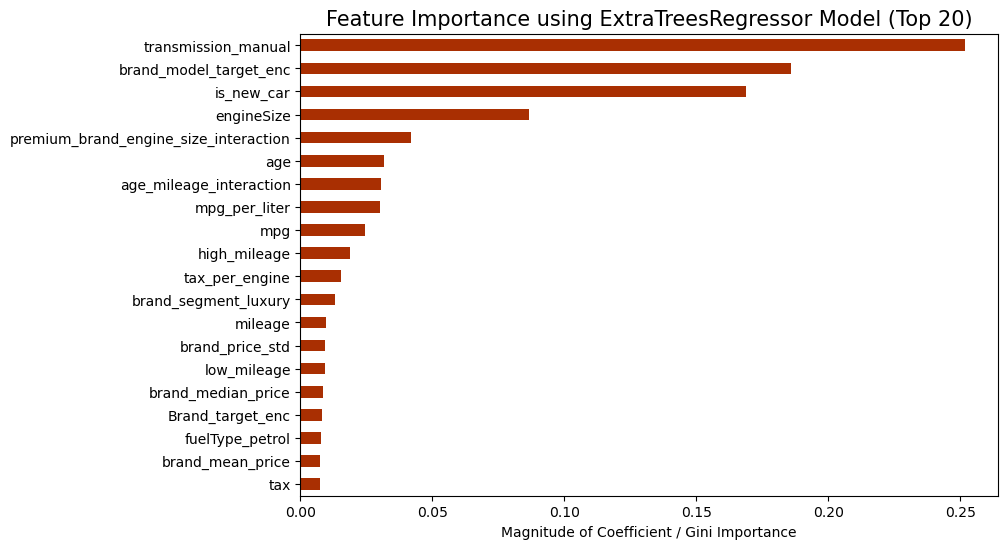


------------------------------------------------------------
MODEL: ExtraTreesRegressor
Selection Criteria: Importance > Mean (0.0270)
Number of features selected: 8
Selected Features: ['engineSize', 'age', 'is_new_car', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'brand_model_target_enc', 'transmission_manual']
------------------------------------------------------------



In [47]:
# --- Lasso Regularization (L1) ---
# O Lasso zera coeficientes sozinho. É o único que faz seleção "nativa".
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train, y_train)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)

plot_importance_unified(abs(lasso_coefs), "Lasso (L1)", is_tree_model=False)
print_selection_results(abs(lasso_coefs), "Lasso (L1)", selection_method="nonzero")


# --- Ridge Regularization (L2) ---
# O Ridge NÃO zera coeficientes (apenas os diminui). 
# A melhor forma de decidir é pegar nos que têm magnitude acima da média.
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train, y_train)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)

plot_importance_unified(abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 
print_selection_results(abs(ridge_coefs), "Ridge (L2)", selection_method="mean")


# --- Random Forest ---
# RF calcula Gini Importance. Raramente é zero.
# Usamos a regra da média (SelectFromModel default).
rf_model_emb = RandomForestRegressor(n_estimators=100, random_state=37, n_jobs=-1)
rf_model_emb.fit(X_train, y_train)
rf_importance = pd.Series(rf_model_emb.feature_importances_, index=X_train.columns)

plot_importance_unified(rf_importance, "Random Forest", is_tree_model=True) 
print_selection_results(rf_importance, "Random Forest", selection_method="mean")


# --- Extra Trees Regressor ---
# Similar ao RF. Usamos a regra da média.
et_model = ExtraTreesRegressor(n_estimators=100, random_state=37, n_jobs=-1)
et_model.fit(X_train, y_train)
et_importance = pd.Series(et_model.feature_importances_, index=X_train.columns)

plot_importance_unified(et_importance, "ExtraTreesRegressor", is_tree_model=True) 
print_selection_results(et_importance, "ExtraTreesRegressor", selection_method="mean")

In [48]:
X_train.columns

Index(['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'mpg_is_missing', 'tax_is_missing',
       'engineSize_is_missing', 'year_is_missing', 'brand_mean_price',
       'brand_median_price', 'brand_price_std', 'brand_count', 'age',
       'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage',
       'low_mileage', 'age_mileage_interaction',
       'premium_brand_engine_size_interaction', 'tax_per_engine',
       'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc',
       'transmission_manual', 'transmission_other', 'transmission_semi auto',
       'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid',
       'fuelType_other', 'fuelType_petrol', 'fuelType_unknown',
       'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

  
| Predictor                                 | Spearman (target)|  ANOVA  | RFE LR  | RFE DT  | Lasso |  Ridge  | Random Forest | Extra Trees  | What to do?  |
|-------------------------------------------|------------------|---------|---------|---------|-------|---------|---------------|--------------|--------------|
| mileage                                   | Keep             | Keep    | Keep    | Keep    | Keep  | Keep    | Discard       | Discard      | -            |
| tax                                       | Keep             | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| mpg                                       | Keep             | Keep    | Keep    | Keep    | Keep  | Keep    | Discard       | Discard      | -            |
| engineSize                                | Keep             | Keep    | Keep    | Keep    | Keep  | Keep    | Keep          | Keep         | Keep         |
| paintQuality%                             | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| previousOwners                            | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| mpg_is_missing                            | Discard          | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| tax_is_missing                            | Discard          | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| engineSize_is_missing                     | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| year_is_missing                           | Discard          | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| brand_mean_price                          | Keep             | Keep    | Keep    | Discard | Keep  | Keep    | Discard       | Discard      | -            |
| brand_median_price                        | Keep             | Keep    | Keep    | Discard | Keep  | Keep    | Discard       | Discard      | -            |
| brand_price_std                           | Keep             | Keep    | Keep    | Discard | Keep  | Discard | Discard       | Discard      | -            |
| brand_count                               | Discard          | Keep    | Keep    | Keep    | Keep  | Discard | Discard       | Discard      | -            |
| age                                       | Keep             | Keep    | Keep    | Keep    | Keep  | Keep    | Keep          | Keep         | Keep         |
| is_new_car                                | Keep             | Keep    | Discard | Discard | Keep  | Discard | Discard       | Keep         | -            |
| is_old_car                                | Keep             | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| miles_per_year                            | Keep             | Keep    | Discard | Keep    | Keep  | Discard | Discard       | Discard      | -            |
| high_mileage                              | Keep             | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| low_mileage                               | Keep             | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| age_mileage_interaction                   | Keep             | Keep    | Discard | Keep    | Keep  | Discard | Keep          | Keep         | -            |
| premium_brand_engine_size_interaction     | Keep             | Keep    | Keep    | Keep    | Keep  | Keep    | Discard       | Discard      | -            |
| tax_per_engine                            | Discard          | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| mpg_per_liter                             | Keep             | Keep    | Keep    | Keep    | Keep  | Keep    | Keep          | Keep         | Keep         |
| Brand_target_enc                          | Keep             | Keep    | Keep    | Discard | Keep  | Keep    | Discard       | Discard      | -            |
| brand_model_target_enc                    | Keep             | Keep    | Keep    | Keep    | Keep  | Keep    | Keep          | Keep         | Keep         |
| transmission_manual                       | Keep             | Keep    | Discard | Keep    | Keep  | Discard | Discard       | Keep         | -            |
| transmission_other                        | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| transmission_semi auto                    | Keep             | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| transmission_unknown                      | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| fuelType_electric                         | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| fuelType_hybrid                           | Discard          | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| fuelType_other                            | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| fuelType_petrol                           | Keep             | Keep    | Discard | Discard | Keep  | Discard | Discard       | Discard      | -            |
| fuelType_unknown                          | Discard          | Discard | Discard | Discard | Keep  | Discard | Discard       | Discard      | Discard      |
| brand_segment_luxury                      | Keep             | Keep    | Discard | Discard | Keep  | Keep    | Discard       | Discard      | -            |
| brand_segment_mid_range                   | Discard          | Keep    | Keep    | Discard | Keep  | Discard | Discard       | Discard      | -            |

<hr>

In [ ]:
# Drop 
X_train.drop(columns=['paintQuality%', 'previousOwners', 'engineSize_is_missing', 'year_is_missing', 'tax_per_engine', 'transmission_other', 'transmission_unknown', 'fuelType_electric', 'fuelType_other', 'fuelType_unknown'], inplace=True)
# Drop 
X_val.drop(columns=['paintQuality%', 'previousOwners', 'engineSize_is_missing', 'year_is_missing', 'tax_per_engine', 'transmission_other', 'transmission_unknown', 'fuelType_electric', 'fuelType_other', 'fuelType_unknown'], inplace=True)
# Drop 
X_test.drop(columns=['paintQuality%', 'previousOwners', 'engineSize_is_missing', 'year_is_missing', 'tax_per_engine', 'transmission_other', 'transmission_unknown', 'fuelType_electric', 'fuelType_other', 'fuelType_unknown'], inplace=True)

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods - Multivariable</b></span>
    </h1>
</div>

In [50]:
# Definir tipos de features
numeric_features = [
    'mileage', 'tax', 'mpg', 'engineSize', 
    'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count',
    'age', 'miles_per_year', 'age_mileage_interaction',
    'premium_brand_engine_size_interaction', 'mpg_per_liter',
    'Brand_target_enc', 'brand_model_target_enc'
]

binary_features = [
    'mpg_is_missing', 'tax_is_missing', 'is_new_car', 'is_old_car', 'high_mileage', 
    'low_mileage','transmission_manual', 'transmission_semi auto','fuelType_hybrid',
    'fuelType_petrol','brand_segment_luxury', 'brand_segment_mid_range'
]

##### **Correlation Indices**

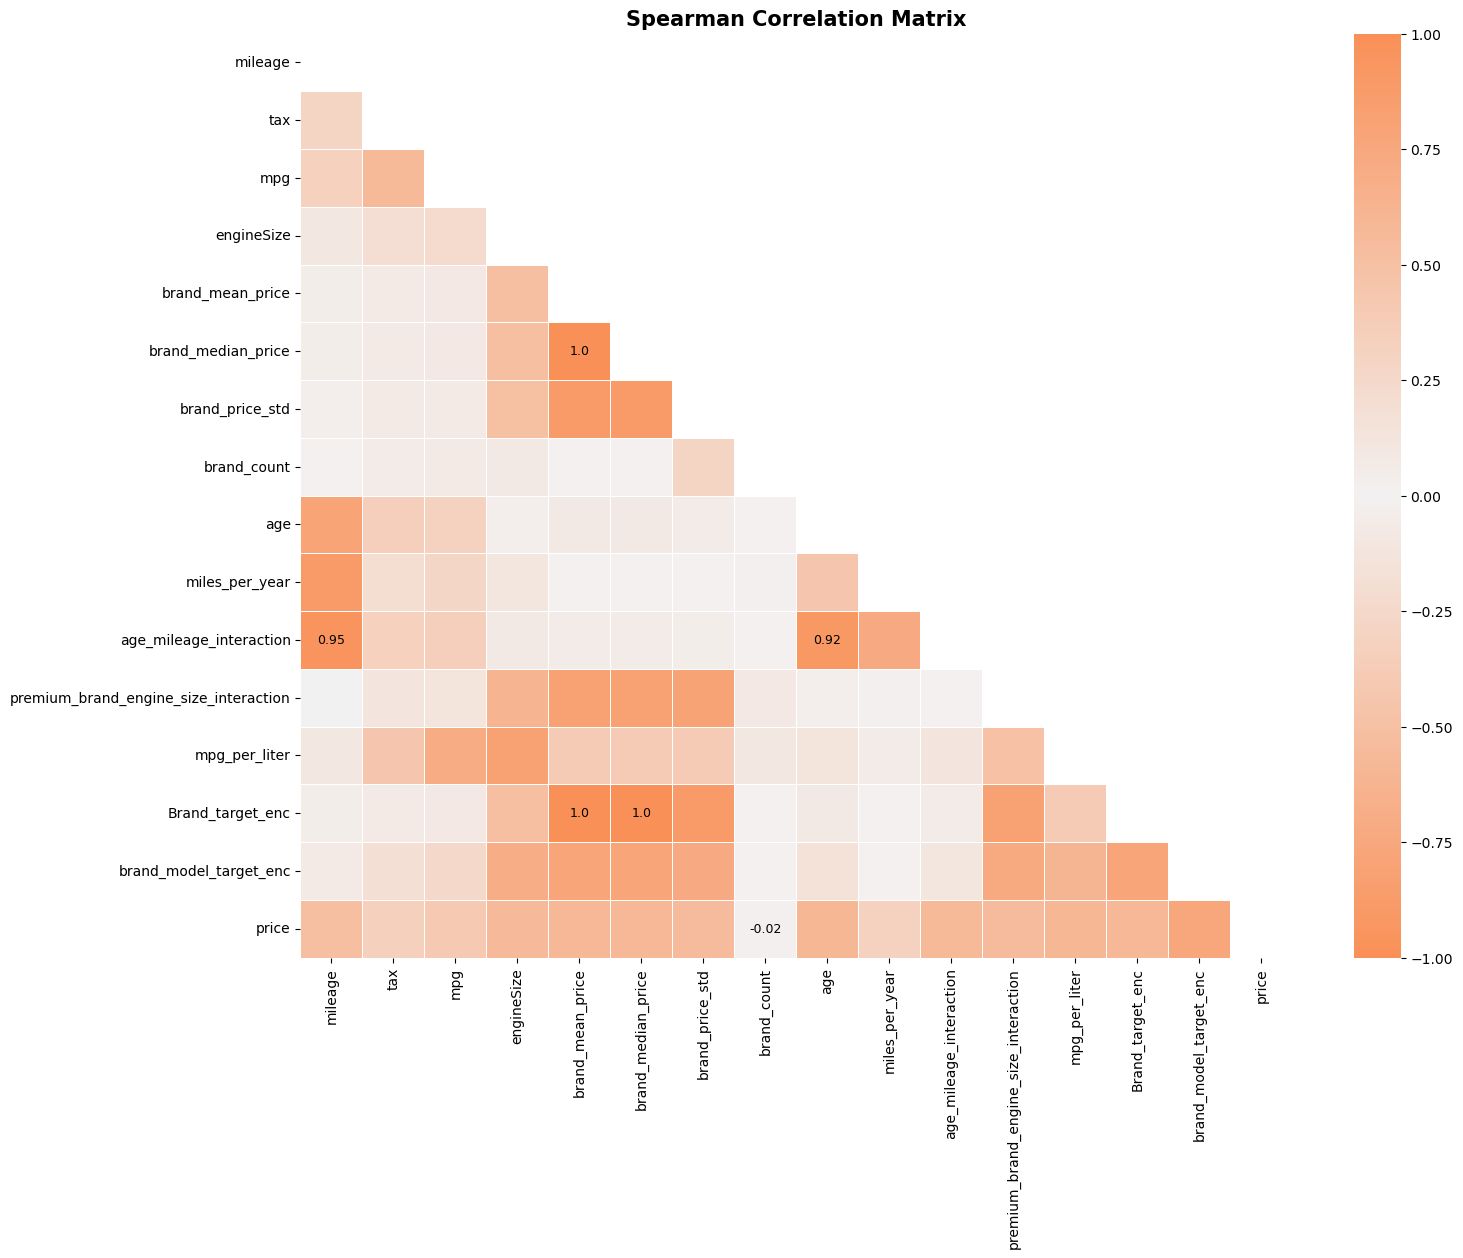

In [51]:
# Create a filtered DataFrame with only numeric and binary columns
X_train_filtered = X_train[numeric_features].copy()

##### Spearman Correlation ####
cor = pd.concat([X_train_filtered, y_train], axis=1).corr(method='spearman').round(2)

TARGET_COL = 'price'
price_index = cor.columns.get_loc(TARGET_COL)

# Create custom annotation matrix for weak correlations
annot_matrix = np.full(cor.shape, "", dtype=object)
for i, col in enumerate(cor.index):
    corr_value = cor.loc[col, TARGET_COL]
    # Annotate only if |corr| < 0.1
    if abs(corr_value) < 0.1 and i != price_index:
        annot_matrix[price_index, i] = f"{corr_value:.2f}"
        
# Create main annotation matrix for strong correlations
# Annotate only if |corr| >= 0.85
mask_annot_main = np.absolute(cor.values) >= 0.9
# Exclude 'price' row and column from this matrix
mask_annot_main[:, price_index] = False
mask_annot_main[price_index, :] = False
annot_main = np.where(mask_annot_main, cor.values.astype(str), "")

# Create the final annotation matrix by combining the two logics
final_annot_matrix = annot_main.copy()
for i in range(cor.shape[0]):
    for j in range(cor.shape[1]):
        # If the main annotation is empty and the weak one has a value, use the weak value
        if final_annot_matrix[i, j] == "" and annot_matrix[i, j] != "":
            final_annot_matrix[i, j] = annot_matrix[i, j]

# Plotting
plt.figure(figsize=(16, 12))

# Create a custom diverging colormap based on orange tones
cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# Create a Mask to hide the upper triangle (to avoid redundancy)
mask = np.zeros_like(cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    data=cor,
    mask=mask,
    cmap=cmap,
    annot=final_annot_matrix, # combined annotation matrix
    fmt='s',                  # Format annotations as strings
    vmin=-1, vmax=1, center=0,# Ensure the scale is from -1 to 1, centered at 0
    linewidths=0.5,
    annot_kws={"fontsize": 9, "color": "black"},
)

plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
plt.show()

Como queremos manter age e Brand_target_enc, vamos remover ager_mileafe inter e brand mean price e median price

In [52]:
# Drop 
X_train.drop(columns=['age_mileage_interaction', 'brand_mean_price', 'brand_median_price'], inplace=True)
# Drop 
X_val.drop(columns=['age_mileage_interaction', 'brand_mean_price', 'brand_median_price'], inplace=True)
# Drop 
X_test.drop(columns=['age_mileage_interaction', 'brand_mean_price', 'brand_median_price'], inplace=True)

##### **Statistical Hypothesis Testing - Chi-squared** 

In [53]:
# Select only categorical columns (including binary variables)

rows = []
alpha = 0.005
# Test all pairs of categorical variables
for c1, c2 in combinations(binary_features, 2):
    # Remove missing values pairwise
    data = pd.concat([X_train[c1], X_train[c2]], axis=1).dropna()
    if data.empty:
        rows.append({"var1": c1, "var2": c2, "test": "-", "p_value": np.nan, "decision": "no_data"})
        continue
    
    # Build contingency table
    ct = pd.crosstab(data.iloc[:,0], data.iloc[:,1])

    # Chi-square test
    _, p, _, _ = stats.chi2_contingency(ct.values, correction=False)

    # if p < alpha, reject H0 (variablesare NOT independent, they are REDUNDANT)
    # if p >= alpha, fail to reject H0 (variables are INDEPENDENT, they are NOT redundant)
    decision = "redundant" if p < alpha else "independent"
    rows.append({"var1": c1, "var2": c2, "p_value": p, "decision": decision})

df_pairs = pd.DataFrame(rows).sort_values("p_value", na_position="last").reset_index(drop=True)

#print all rows
pd.set_option('display.max_rows', None)
display(df_pairs)
#set back to default
pd.reset_option('display.max_rows')

,var1,var2,p_value,decision
0,mpg_is_missing,tax_is_missing,0.000000e+00,redundant
1,mpg_is_missing,brand_segment_mid_range,0.000000e+00,redundant
2,is_old_car,high_mileage,0.000000e+00,redundant
3,is_new_car,transmission_semi auto,0.000000e+00,redundant
4,is_new_car,transmission_manual,0.000000e+00,redundant
5,tax_is_missing,brand_segment_mid_range,0.000000e+00,redundant
6,is_new_car,low_mileage,0.000000e+00,redundant
7,is_new_car,high_mileage,0.000000e+00,redundant
8,transmission_manual,transmission_semi auto,0.000000e+00,redundant
9,transmission_manual,brand_segment_luxury,0.000000e+00,redundant


In [54]:
#pares de certeza redundantes
df_filtrado = df_pairs.loc[df_pairs["p_value"] == 0, ["var1", "var2"]]

{ mpg_is_missing,
  tax_is_missing,
  brand_segment_mid_range,
  is_old_car,
  is_new_car,
  low_mileage,
  high_mileage,
  transmission_semi auto,
  transmission_manual,
  brand_segment_luxury,
  fuelType_petrol,
  fuelType_hybrid }

um grupo redundante por isso so vou manter 1

🎯 low_mileage
Porquê?

✔ Muito preditiva (F ≈ 13 848)
✔ P-value extremamente baixo
✔ Simples e interpretável
✔ Não depende de categorias (fuel/brand/transmission) → generaliza melhor
✔ Representa o cluster mileage/new/old/segment/fuel/transmission
✔ Levada mais vezes como “Keep” nos modelos importantes (Lasso, Ridge, RF, ET)
✔ Substitui quase todas as outras no grupo (is_new_car, high_mileage, fuelType_petrol, etc.)

In [55]:
# Drop 
X_train.drop(columns=['mpg_is_missing', 'tax_is_missing', 'brand_segment_mid_range','is_old_car','is_new_car','high_mileage', 'transmission_semi auto', 'low_mileage', 'brand_segment_luxury', 'fuelType_petrol', 'fuelType_hybrid'], inplace=True)
# Drop 
X_val.drop(columns=['mpg_is_missing', 'tax_is_missing', 'brand_segment_mid_range','is_old_car','is_new_car','high_mileage', 'transmission_semi auto', 'low_mileage', 'brand_segment_luxury', 'fuelType_petrol', 'fuelType_hybrid'], inplace=True)
# Drop 
X_test.drop(columns=['mpg_is_missing', 'tax_is_missing', 'brand_segment_mid_range','is_old_car','is_new_car','high_mileage', 'transmission_semi auto', 'low_mileage', 'brand_segment_luxury', 'fuelType_petrol', 'fuelType_hybrid'], inplace=True)

In [56]:
X_train.shape

(60769, 13)

# <span style="color: #ffffff;">3 | Regression Benchmarking</span>

<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>


We are dealing with a **supervised regression problem**, as the target variable `price` is **numerical and continuous**. The goal is to train a model that learns the relationship between car characteristics (`Brand`, `model`, `mileage`, `year`, ...) and `price`, allowing it to predict the value of unseen cars.

Both **linear models** such as *Linear Regression*, *Ridge*, and *ElasticNet*, and **non-linear models** such as *KNN*, *Decision Tree*, and *SVR* can be applied to this problem. We focus on predicting the **median price** because car prices often include **outliers or extreme values** that can distort mean-based predictions. The **median is robust** to such extremes, providing more reliable predictions for typical cars.

To target the median, we use **median-based loss functions**, specifically the *Mean Absolute Error* (MAE). This choice is motivated by two factors: first, MAE is strictly consistent for the median, and second, it is the evaluation metric used in the relevant Kaggle competition, ensuring that model optimization aligns with competition scoring. Additionally, we monitor **Root Mean Squared Error (RMSE)** to assess the impact of larger errors and consider the **Pinball Loss** to explore the distribution of car prices. The Pinball Loss, also known as Quantile Loss, generalizes the MAE by allowing the model to predict conditional quantiles of the target variable. It introduces an asymmetry in the penalization of errors controlled by the quantile parameter α, which ranges from zero to one. When **α = 0.5**, the Pinball Loss is equivalent to MAE up to a constant. Beyond the median, Pinball Loss can estimate other quantiles, providing flexibility for predicting lower or upper price bounds. For instance, lower quantiles could support conservative pricing strategies to minimize risk in purchasing, while higher quantiles could indicate potential market ceilings, helping the company set competitive yet safe resale prices.

**Note**: We didn't have time to explore Pinball Loss for different quantiles, but it could be an interesting avenue for future work.


In [ ]:
# EVALUATION FUNCTION 
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

# MODELS AND HYPERPARAMETER GRIDS
models_and_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # Here we have no hyperparameters to tune
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=37),
        "params": {
            'alpha': [0.1, 1.0, 10.0],   # Regularization strength
            'l1_ratio': [0.1, 0.5, 0.9]  # Mix between L1 and L2
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=37),
        "params": {
            'max_depth': [5, 10, None], # Max depth to control overfitting
            'min_samples_leaf': [2, 5, 10]  # Min samples per leaf
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100],      # Number of trees
            'max_depth': [10, 20, 30],      # Max depth of trees
            'min_samples_leaf': [2, 4, 6] # Min samples per leaf
        }
    },
    "K-Neighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [3, 5, 7, 10],   # Number of neighbors
            'weights': ['uniform', 'distance'] # Weight function
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=37),        
        "params": {
            'learning_rate': [0.1],
            'max_depth': [3,7,10,12,15],
            'min_samples_leaf': [3,5],
            'n_estimators': [200, 400, 500, 600],
            'subsample': [1.0, 0.8, 0.9]
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'kernel': ['rbf'],
            'C': [1, 10, 100],      # Regularization parameter
            'gamma': ['auto'] # Kernel coefficient
        }
    }
}


# MODEL TRAINING AND EVALUATION LOOP
results_list = []

# Iterate over each model defined in the dictionary
for model_name, config in models_and_grids.items():
    print(f"--- Processing model: {model_name} ---")
    param_grid = ParameterGrid(config['params'])
    best_model_results = None
    best_val_mae = float('inf')

    # Handle Linear Regression which has no grid
    if not list(param_grid):
        model = config['model']
        # Fit the model directly using X_train
        model.fit(X_train, y_train)
        scores = evaluate_model(model, X_train, y_train, X_val, y_val)
        best_model_results = {
            'Model': model_name,
            'Best Params': '{}',
            **scores
        }
    else:
        # Iterate over each combination of hyperparameters
        for params in param_grid:
            model = config['model']
            model.set_params(**params)
            
            # Fit the model directly using X_train
            model.fit(X_train, y_train)
            
            # Evaluate the model using the new evaluation function
            scores = evaluate_model(model, X_train, y_train, X_val, y_val)
            
            print(f"  Params: {params} -> Val MAE: {scores['Val MAE']:.4f}")
            
            # Store the best result based on validation MAE
            if scores['Val MAE'] < best_val_mae:
                best_val_mae = scores['Val MAE']
                best_model_results = {
                    'Model': model_name,
                    'Best Params': str(params),
                    **scores
                }
    
    results_list.append(best_model_results)
    print(f"Best validation MAE for {model_name}: {best_val_mae:.4f}\n")


# GET FINAL RESULTS
results_df = pd.DataFrame(results_list)

# Sort the results by validation MAE
results_df = results_df.sort_values(by='Val MAE', ascending=True)

# Reorder columns for better readability with the new metrics
columns_order = [
    'Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Train RMSE', 
    'Val Pinball (α=0.5)', 'Train Pinball (α=0.5)', 'Best Params'
]
results_df = results_df[columns_order]
display(results_df)

--- Processing model: Linear Regression ---
  Params: {} -> Val MAE: 2812.6199
Best validation MAE for Linear Regression: 2812.6199

--- Processing model: ElasticNet ---
  Params: {'alpha': 0.1, 'l1_ratio': 0.1} -> Val MAE: 2782.6979


  Params: {'alpha': 0.1, 'l1_ratio': 0.5} -> Val MAE: 2788.4917
  Params: {'alpha': 0.1, 'l1_ratio': 0.9} -> Val MAE: 2806.6563
  Params: {'alpha': 1.0, 'l1_ratio': 0.1} -> Val MAE: 3084.5182
  Params: {'alpha': 1.0, 'l1_ratio': 0.5} -> Val MAE: 2898.9188
  Params: {'alpha': 1.0, 'l1_ratio': 0.9} -> Val MAE: 2782.4389
  Params: {'alpha': 10.0, 'l1_ratio': 0.1} -> Val MAE: 5250.0347
  Params: {'alpha': 10.0, 'l1_ratio': 0.5} -> Val MAE: 4570.7097
  Params: {'alpha': 10.0, 'l1_ratio': 0.9} -> Val MAE: 3135.7459
Best validation MAE for ElasticNet: 2782.4389

--- Processing model: Decision Tree ---
  Params: {'max_depth': 5, 'min_samples_leaf': 2} -> Val MAE: 2668.2777
  Params: {'max_depth': 5, 'min_samples_leaf': 5} -> Val MAE: 2668.2777
  Params: {'max_depth': 5, 'min_samples_leaf': 10} -> Val MAE: 2668.2777
  Params: {'max_depth': 10, 'min_samples_leaf': 2} -> Val MAE: 1791.6141
  Params: {'max_depth': 10, 'min_samples_leaf': 5} -> Val MAE: 1781.0920
  Params: {'max_depth': 10, 'min_sa

c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100} -> Val MAE: 1579.2278


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100} -> Val MAE: 1580.1599


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 100} -> Val MAE: 1590.6180


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 100} -> Val MAE: 1315.4845


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 20, 'min_samples_leaf': 4, 'n_estimators': 100} -> Val MAE: 1340.8842


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 20, 'min_samples_leaf': 6, 'n_estimators': 100} -> Val MAE: 1370.3706


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 100} -> Val MAE: 1323.1146


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 30, 'min_samples_leaf': 4, 'n_estimators': 100} -> Val MAE: 1343.5895


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


  Params: {'max_depth': 30, 'min_samples_leaf': 6, 'n_estimators': 100} -> Val MAE: 1370.9383
Best validation MAE for Random Forest: 1315.4845

--- Processing model: K-Neighbors ---
  Params: {'n_neighbors': 3, 'weights': 'uniform'} -> Val MAE: 1584.9796
  Params: {'n_neighbors': 3, 'weights': 'distance'} -> Val MAE: 1553.4845
  Params: {'n_neighbors': 5, 'weights': 'uniform'} -> Val MAE: 1578.8771
  Params: {'n_neighbors': 5, 'weights': 'distance'} -> Val MAE: 1527.9317
  Params: {'n_neighbors': 7, 'weights': 'uniform'} -> Val MAE: 1587.9468
  Params: {'n_neighbors': 7, 'weights': 'distance'} -> Val MAE: 1522.1532
  Params: {'n_neighbors': 10, 'weights': 'uniform'} -> Val MAE: 1614.5559
  Params: {'n_neighbors': 10, 'weights': 'distance'} -> Val MAE: 1532.8260
Best validation MAE for K-Neighbors: 1522.1532

--- Processing model: Gradient Boosting ---


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


  Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 200, 'subsample': 1.0} -> Val MAE: 1733.4533


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


  Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 200, 'subsample': 0.8} -> Val MAE: 1753.0951


c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

print("Treinando modelo com todas as features para obter importâncias...")

# Treinar modelo UMA VEZ com todas as features
model = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=10,
    min_samples_leaf=5,
    n_estimators=200,
    subsample=1.0,
    random_state=37
)

model.fit(X_train, y_train.values.ravel())

# Obter importâncias
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📊 Feature Importances:")
display(feature_importance)

# Testar removendo features menos importantes ITERATIVAMENTE
print("\n" + "="*70)
print("Testando diferentes números de features (das mais para menos importantes)...")
print("="*70)

results = []

# Ordenar features por importância (descendente)
sorted_features = feature_importance['feature'].tolist()

for n_features in range(1, len(sorted_features) + 1):
    # Usar apenas as top N features mais importantes
    features_to_use = sorted_features[:n_features]
    
    print(f"[{n_features:2d}/{len(sorted_features)}] Training with {n_features} feature(s)...", end=" ", flush=True)
    
    # Treinar modelo
    model_temp = GradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=10,
        min_samples_leaf=5,
        n_estimators=200,
        subsample=1.0,
        random_state=37,
        verbose=0
    )
    
    model_temp.fit(X_train[features_to_use], y_train.values.ravel())
    
    # Avaliar em TRAIN e VAL
    train_mae = mean_absolute_error(y_train, model_temp.predict(X_train[features_to_use]))
    val_mae = mean_absolute_error(y_val, model_temp.predict(X_val[features_to_use]))
    
    # Calcular gap (indicador de overfitting)
    gap = val_mae - train_mae
    gap_percent = (gap / train_mae) * 100
    
    results.append({
        'n_features': n_features,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'gap': gap,
        'gap_percent': gap_percent,
        'features': features_to_use.copy()
    })
    
    print(f"Train: {train_mae:.2f} | Val: {val_mae:.2f} | Gap: {gap:.2f} ({gap_percent:.1f}%)")

print("\n" + "="*70)
print("✓ CONCLUÍDO!")

# Análise dos resultados
results_df = pd.DataFrame(results)

# Critério 1: Menor Val MAE (pode ter overfitting)
best_val_idx = results_df['val_mae'].idxmin()
best_val = results_df.loc[best_val_idx]

# Critério 2: Melhor balanço (Val MAE + baixo overfitting)
# Penalizar modelos com gap > 10%
results_df['score'] = results_df['val_mae'] * (1 + results_df['gap_percent'] / 100)
best_balanced_idx = results_df['score'].idxmin()
best_balanced = results_df.loc[best_balanced_idx]

# Critério 3: Menor gap (menos overfitting)
best_gap_idx = results_df['gap'].idxmin()
best_gap = results_df.loc[best_gap_idx]

print(f"\n" + "="*70)
print("🏆 ANÁLISE DE RESULTADOS")
print("="*70)

print(f"\n1️⃣ MENOR VAL MAE (pode ter overfitting):")
print(f"   Features: {best_val['n_features']}")
print(f"   Train MAE: {best_val['train_mae']:.2f}")
print(f"   Val MAE: {best_val['val_mae']:.2f}")
print(f"   Gap: {best_val['gap']:.2f} ({best_val['gap_percent']:.1f}%)")
if best_val['gap_percent'] > 15:
    print(f"   ⚠️ OVERFITTING detectado! (gap > 15%)")

print(f"\n2️⃣ MELHOR BALANÇO (Val MAE + baixo overfitting):")
print(f"   Features: {best_balanced['n_features']}")
print(f"   Train MAE: {best_balanced['train_mae']:.2f}")
print(f"   Val MAE: {best_balanced['val_mae']:.2f}")
print(f"   Gap: {best_balanced['gap']:.2f} ({best_balanced['gap_percent']:.1f}%)")
print(f"   ✅ Modelo recomendado para produção")

print(f"\n3️⃣ MENOR OVERFITTING (menor gap):")
print(f"   Features: {best_gap['n_features']}")
print(f"   Train MAE: {best_gap['train_mae']:.2f}")
print(f"   Val MAE: {best_gap['val_mae']:.2f}")
print(f"   Gap: {best_gap['gap']:.2f} ({best_gap['gap_percent']:.1f}%)")

# Mostrar features do modelo balanceado
print(f"\n📋 Features do modelo BALANCEADO ({best_balanced['n_features']} features):")
for i, feat in enumerate(best_balanced['features'], 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"  {i:2d}. {feat:40s} (importance: {imp:.4f})")

# Plot dos resultados
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: MAE vs Number of Features
ax1.plot(results_df['n_features'], results_df['train_mae'], 
         marker='o', label='Train MAE', linewidth=2, markersize=6)
ax1.plot(results_df['n_features'], results_df['val_mae'], 
         marker='s', label='Val MAE', linewidth=2, markersize=6)
ax1.axvline(x=best_balanced['n_features'], color='green', linestyle='--', 
            label=f'Best Balanced: {best_balanced["n_features"]} features', linewidth=2)
ax1.axvline(x=best_val['n_features'], color='red', linestyle=':', 
            label=f'Lowest Val MAE: {best_val["n_features"]} features', linewidth=2)
ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_title('MAE vs Number of Features', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Overfitting Gap
ax2.plot(results_df['n_features'], results_df['gap_percent'], 
         marker='o', color='orange', linewidth=2, markersize=6)
ax2.axhline(y=15, color='red', linestyle='--', label='15% threshold', linewidth=2)
ax2.axvline(x=best_balanced['n_features'], color='green', linestyle='--', 
            label=f'Best Balanced: {best_balanced["n_features"]} features', linewidth=2)
ax2.fill_between(results_df['n_features'], 0, 15, alpha=0.2, color='green', label='Safe zone')
ax2.fill_between(results_df['n_features'], 15, results_df['gap_percent'].max(), 
                  alpha=0.2, color='red', label='Overfitting zone')
ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('Overfitting Gap (%)', fontsize=12)
ax2.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabela completa com destaque
print("\n📊 RESULTADOS COMPLETOS:")
display_df = results_df[['n_features', 'train_mae', 'val_mae', 'gap', 'gap_percent']].copy()

# Adicionar coluna de status
def get_status(row):
    if row.name == best_balanced_idx:
        return '✅ RECOMENDADO'
    elif row.name == best_val_idx:
        return '⚠️ Menor Val MAE'
    elif row['gap_percent'] > 15:
        return '❌ Overfitting'
    else:
        return ''

display_df['status'] = display_df.apply(get_status, axis=1)
display(display_df)

Treinando modelo com todas as features para obter importâncias...

📊 Feature Importances:


,feature,importance
26,brand_model_target_enc,0.450448
21,age_mileage_interaction,0.194056
3,engineSize,0.131898
24,mpg_per_liter,0.049379
15,age,0.046749
22,premium_brand_engine_size_interaction,0.027961
2,mpg,0.025899
0,mileage,0.017232
16,is_new_car,0.014862
27,transmission_manual,0.008686



Testando diferentes números de features (das mais para menos importantes)...
[ 1/38] Training with 1 feature(s)... Train MAE: 4349.47 | Val MAE: 4371.50
[ 2/38] Training with 2 feature(s)... Train MAE: 1958.84 | Val MAE: 2323.76
[ 3/38] Training with 3 feature(s)... Train MAE: 1395.73 | Val MAE: 1695.97
[ 4/38] Training with 4 feature(s)... Train MAE: 1082.67 | Val MAE: 1412.63
[ 5/38] Training with 5 feature(s)... Train MAE: 1017.51 | Val MAE: 1355.39
[ 6/38] Training with 6 feature(s)... Train MAE: 1012.92 | Val MAE: 1349.28
[ 7/38] Training with 7 feature(s)... Train MAE: 1006.88 | Val MAE: 1343.64
[ 8/38] Training with 8 feature(s)... Train MAE: 946.01 | Val MAE: 1326.49
[ 9/38] Training with 9 feature(s)... Train MAE: 946.01 | Val MAE: 1327.08
[10/38] Training with 10 feature(s)... Train MAE: 926.51 | Val MAE: 1305.42
[11/38] Training with 11 feature(s)... Train MAE: 917.16 | Val MAE: 1304.84
[12/38] Training with 12 feature(s)... Train MAE: 899.12 | Val MAE: 1292.28
[13/38] Trai

KeyboardInterrupt: 

**Model Selection and Final Strategy**

Upon reviewing the model performance across our validation set, the **Support Vector Regressor (SVR)** emerged as the most robust model, achieving a Validation MAE of 2798.12 and a Training MAE of 2758.66. This was the smallest gap between these scores we achieved indicating this is the model with the least overfitting (but overfitting nonetheless), making the SVR the most reliable and generalizable model.

However, for the purpose of this Kaggle competition, where maximizing our leaderboard rank is one of the objectives, we are prioritizing the model with the best predictive performance on the validation set. In this regard, the **Gradient Boosting** model was the clear top performer, achieving a significantly lower **Validation MAE of 1300.44** (with a Training MAE of 1228.14). While this model shows a higher degree of overfitting compared to the SVR, its superior validation score makes it the strategic choice for our submission.

**Note**: To ensure a fair comparison, our methodology involved testing six distinct hyperparameter combinations for each algorithm, giving every model an equitable chance to find an optimal configuration.

We will now proceed by retraining our best Gradient Boosting model on the combined training and validation datasets. This will allow the model to learn from all available data before generating the final price predictions for the test set.


In [ ]:
final_features =['brand_model_target_enc', 'age_mileage_interaction', 'engineSize', 'mpg_per_liter', 'age',
                    'premium_brand_engine_size_interaction', 'mpg', 'mileage', 'is_new_car', 'transmission_manual',
                    'miles_per_year', 'tax_per_engine']

X_train_12 = X_train_original[final_features].copy()
X_val_12 = X_val_original[final_features].copy()
X_test_12 = X_test_original[final_features].copy()

In [ ]:
#Combining training and validation datasets
X_train_full = pd.concat([X_train_12, X_val_12])
y_train_full = pd.concat([y_train, y_val])

print(f"Final training set dimensions (X): {X_train_full.shape}")
print(f"Final training set dimensions (y): {y_train_full.shape}")

Final training set dimensions (X): (75962, 12)
Final training set dimensions (y): (75962, 2)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd

print("="*70)
print("ENSEMBLE COM 3 MODELOS: GB + RF + KNN")
print("="*70)

# Verificar dimensões
print("\n📊 Dimensões:")
print(f"X_train_full: {X_train_full.shape}")
print(f"X_test_12:    {X_test_12.shape}")

# Converter target
y_train_array = y_train_full['price'].values if isinstance(y_train_full, pd.DataFrame) else y_train_full.values.ravel()

# ============================================================================
# TREINAR OS 3 MODELOS
# ============================================================================
print("\n" + "="*70)
print("🚀 TREINANDO MODELOS")
print("="*70)

# Modelo 1: Gradient Boosting
print("\n1. Gradient Boosting...", end=" ", flush=True)
gb_model = GradientBoostingRegressor(
    learning_rate=0.1,
    max_depth=10,
    min_samples_leaf=5,
    n_estimators=400,
    subsample=1.0,
    random_state=37,
    verbose=0
)
gb_model.fit(X_train_full, y_train_array)
print("✓")

# Modelo 2: Random Forest
print("2. Random Forest...", end=" ", flush=True)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=2,
    random_state=37,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_full, y_train_array)
print("✓")

# Modelo 3: KNN
print("3. K-Neighbors...", end=" ", flush=True)
knn_model = KNeighborsRegressor(
    n_neighbors=7,
    weights='distance',  # Dá mais peso a vizinhos próximos
    n_jobs=-1
)
knn_model.fit(X_train_full, y_train_array)
print("✓")

# ============================================================================
# FAZER PREVISÕES
# ============================================================================
print("\n" + "="*70)
print("🔮 FAZER PREVISÕES NO TEST SET")
print("="*70)

print("\nGerando previsões...", end=" ", flush=True)
gb_preds = gb_model.predict(X_test_12)
rf_preds = rf_model.predict(X_test_12)
knn_preds = knn_model.predict(X_test_12)
print("✓")

# ============================================================================
# CRIAR ENSEMBLES COM DIFERENTES COMBINAÇÕES
# ============================================================================
print("\n" + "="*70)
print("📄 CRIAR SUBMISSÕES")
print("="*70)

# Combinações de pesos
weight_combos = [
    # (GB, RF, KNN, Label)
    (0.80, 0.15, 0.05, "3models_80GB_15RF_5KNN"),        
    (0.65, 0.25, 0.10, "3models_75GB_15RF_10KNN"),   
    (0.60, 0.25, 0.15, "3models_60GB_25RF_15KNN"),   
    (0.55, 0.30, 0.15, "3models_55GB_30RF_15KNN"),  
]

print("\nCriando ficheiros...")
for gb_w, rf_w, knn_w, label in weight_combos:
    # Ensemble
    ensemble_preds = gb_w * gb_preds + rf_w * rf_preds + knn_w * knn_preds
    
    # Submissão
    submission_df = pd.DataFrame({
        'carID': X_test_12.index,
        'price': ensemble_preds
    })
    
    filename = f"./project_data/Group37_Ensemble_{label}.csv"
    submission_df.to_csv(filename, index=False)


print(f"\n✓ {len(weight_combos)} ficheiros criados!")


ENSEMBLE COM 3 MODELOS: GB + RF + KNN

📊 Dimensões:
X_train_full: (75962, 12)
X_test_12:    (32567, 12)

🚀 TREINANDO MODELOS

1. Gradient Boosting... 

✓
2. Random Forest... ✓
3. K-Neighbors... ✓

🔮 FAZER PREVISÕES NO TEST SET

Gerando previsões... ✓

📄 CRIAR SUBMISSÕES

Criando ficheiros...
   ./project_data/Group37_Ensemble_3models_80GB_15RF_5KNN.csv
   ./project_data/Group37_Ensemble_3models_75GB_15RF_10KNN.csv
   ./project_data/Group37_Ensemble_3models_60GB_25RF_15KNN.csv
   ./project_data/Group37_Ensemble_3models_55GB_30RF_15KNN.csv

✓ 4 ficheiros criados!


final

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

print("="*70)
print("AVALIAÇÃO: MAE no conjunto de VALIDAÇÃO")
print("="*70)

# Converter y_val para array se necessário
y_val_array = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

print(f"\n📊 Dimensões:")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val_array.shape}")

# ============================================================================
# TREINAR MODELOS E PREVER NO CONJUNTO DE VALIDAÇÃO
# ============================================================================

y_train_array = y_train_full['price'].values if isinstance(y_train_full, pd.DataFrame) else y_train_full.values.ravel()

# Lista de configurações para testar
configs = [
    (400, 1.0, 0.1, "baseline_400est_sub1.0"),
    (500, 0.9, 0.1, "v1_500est_sub0.9"),
    (500, 0.85, 0.1, "v2_500est_sub0.85"),
    (600, 0.9, 0.1, "v3_600est_sub0.9"),
    (600, 0.85, 0.1, "v4_600est_sub0.85"),
]

results = []

print("\n" + "="*70)
print("TREINANDO E AVALIANDO CONFIGURAÇÕES")
print("="*70)

# RF e KNN (fixos)
print("\n🚀 Treinando RF e KNN (fixos)...")
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_leaf=2,
    random_state=37, n_jobs=-1, verbose=0
)
rf_model.fit(X_train_full, y_train_array)
rf_preds_val = rf_model.predict(X_val)

knn_model = KNeighborsRegressor(n_neighbors=7, weights='distance', n_jobs=-1)
knn_model.fit(X_train_full, y_train_array)
knn_preds_val = knn_model.predict(X_val)
print("✓")

# Testar cada configuração de GB
for n_est, subsample, lr, label in configs:
    print(f"\n📊 {label}...", end=" ", flush=True)
    
    # Treinar GB
    gb_model = GradientBoostingRegressor(
        learning_rate=lr,
        max_depth=10,
        min_samples_leaf=5,
        n_estimators=n_est,
        subsample=subsample,
        random_state=37,
        verbose=0
    )
    gb_model.fit(X_train_full, y_train_array)
    
    # Prever no VALIDATION set
    gb_preds_val = gb_model.predict(X_val)
    
    # Ensemble 80/15/5
    ensemble_preds_val = 0.80 * gb_preds_val + 0.15 * rf_preds_val + 0.05 * knn_preds_val
    
    # Calcular MAE no validation set
    mae_val = mean_absolute_error(y_val_array, ensemble_preds_val)
    
    results.append({
        'Config': label,
        'n_estimators': n_est,
        'subsample': subsample,
        'learning_rate': lr,
        'VAL_MAE': mae_val
    })
    
    print(f"✓ VAL MAE: £{mae_val:,.2f}")

# ============================================================================
# RESUMO DOS RESULTADOS
# ============================================================================
print("\n" + "="*70)
print("📊 RESUMO: MAE NO CONJUNTO DE VALIDAÇÃO")
print("="*70)

results_df = pd.DataFrame(results).sort_values('VAL_MAE')

print(f"\n{'Rank':<6} {'Config':<25} {'n_est':<8} {'subsample':<11} {'VAL MAE':<12} Status")
print("="*75)

for i, row in results_df.iterrows():
    rank = results_df.index.get_loc(i) + 1
    marker = "⭐" if rank == 1 else ("🔥" if rank == 2 else ("💡" if rank == 3 else "  "))
    print(f"{rank:<6} {row['Config']:<25} {row['n_estimators']:<8} {row['subsample']:<11.2f} £{row['VAL_MAE']:<10,.2f} {marker}")

# Melhor configuração
best_config = results_df.iloc[0]

print("\n" + "="*70)
print("✅ MELHOR CONFIGURAÇÃO (no validation set):")
print("="*70)
print(f"   Config:       {best_config['Config']}")
print(f"   n_estimators: {best_config['n_estimators']}")
print(f"   subsample:    {best_config['subsample']}")
print(f"   VAL MAE:      £{best_config['VAL_MAE']:,.2f}")

# Diferença vs baseline
if len(results_df) > 1:
    baseline_mae = results_df[results_df['Config'].str.contains('baseline')]['VAL_MAE'].values
    if len(baseline_mae) > 0:
        improvement = baseline_mae[0] - best_config['VAL_MAE']
        print(f"\n💡 Melhoria vs baseline: £{improvement:,.2f}")
        if improvement > 0:
            print(f"   ✅ Melhorou {improvement:.2f} pontos!")
        else:
            print(f"   ⚠️ Piorou {abs(improvement):.2f} pontos")

print("\n" + "="*70)
print("🎯 PRÓXIMOS PASSOS:")
print("="*70)
print("   1. A configuração ⭐ tem o melhor MAE no validation set")
print("   2. Treina essa configuração e gera submissão para Kaggle")
print("   3. O MAE no Kaggle pode ser ±10-20 pontos diferente")
print("="*70)

AVALIAÇÃO: MAE no conjunto de VALIDAÇÃO

📊 Dimensões:
   X_val: (15193, 13)
   y_val: (15193,)

TREINANDO E AVALIANDO CONFIGURAÇÕES

🚀 Treinando RF e KNN (fixos)...


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

print("="*70)
print("TESTES RÁPIDOS: Micro-ajustes em torno do melhor")
print("Baseline: 500est, sub0.9, lr0.1 → MAE £1,260.43")
print("="*70)

# ============================================================================
# IDENTIFICAR DATASETS CORRETOS
# ============================================================================

# OPÇÃO A: Se tens X_val_12
try:
    X_val_processed = X_val_12
    print("\n✓ Usando X_val_12")
except:
    pass

# Verificar que têm as mesmas colunas
print(f"\nX_train_full: {X_train_.shape} - {list(X_train_full.columns[:3])}...")
print(f"X_val_processed: {X_val_12.shape} - {list(X_val_processed.columns[:3])}...")
print(f"X_test_12: {X_test_12.shape} - {list(X_test_12.columns[:3])}...")

assert list(X_train_full.columns) == list(X_val_processed.columns), "❌ COLUNAS DIFERENTES!"
print("\n✅ COLUNAS IGUAIS! Podemos continuar.")

# ============================================================================
# CONTINUAR COM O CÓDIGO
# ============================================================================

y_train_array = y_train_full['price'].values if isinstance(y_train_full, pd.DataFrame) else y_train_full.values.ravel()
y_val_array = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# RF e KNN fixos
print("\n🚀 Treinando RF e KNN...")
rf_model = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_leaf=2,
    random_state=37, n_jobs=-1, verbose=0
)
rf_model.fit(X_train_full, y_train_array)
rf_preds_val = rf_model.predict(X_val_processed)  # ← CORRIGIDO
rf_preds_test = rf_model.predict(X_test_12)

knn_model = KNeighborsRegressor(n_neighbors=7, weights='distance', n_jobs=-1)
knn_model.fit(X_train_full, y_train_array)
knn_preds_val = knn_model.predict(X_val_processed)  # ← CORRIGIDO
knn_preds_test = knn_model.predict(X_test_12)
print("✓")

# Micro-ajustes em torno de 500/0.9/0.1
configs = [
    # (n_est, sub, lr, md, label)
    (500, 0.90, 0.10, 10, "baseline"),
    (500, 0.85, 0.10, 10, "sub_down"),
    (500, 0.90, 0.08, 10, "lr_down"),
    (500, 0.90, 0.12, 10, "lr_up"),
    (500, 0.90, 0.10, 12, "depth_up"),
    (600, 0.90, 0.10, 10, "more_trees"),
    (500, 0.85, 0.08, 12, "combo_conservative"),
]

results = []

print("\n" + "="*70)
print("TESTANDO CONFIGURAÇÕES")
print("="*70)

for n_est, sub, lr, md, label in configs:
    print(f"\n📊 {label}...", end=" ", flush=True)
    
    gb_model = GradientBoostingRegressor(
        learning_rate=lr,
        max_depth=md,
        min_samples_leaf=5,
        n_estimators=n_est,
        subsample=sub,
        random_state=37,
        verbose=0
    )
    gb_model.fit(X_train_full, y_train_array)
    
    # Validation MAE
    gb_preds_val = gb_model.predict(X_val_processed)  # ← CORRIGIDO
    ensemble_val = 0.80 * gb_preds_val + 0.15 * rf_preds_val + 0.05 * knn_preds_val
    mae_val = mean_absolute_error(y_val_array, ensemble_val)
    
    # Test predictions
    gb_preds_test = gb_model.predict(X_test_12)
    ensemble_test = 0.80 * gb_preds_test + 0.15 * rf_preds_test + 0.05 * knn_preds_test
    
    results.append({
        'label': label,
        'n_est': n_est,
        'sub': sub,
        'lr': lr,
        'md': md,
        'val_mae': mae_val,
        'test_preds': ensemble_test
    })
    
    print(f"✓ VAL MAE: £{mae_val:,.2f}")

# Ordenar por VAL MAE
results_sorted = sorted(results, key=lambda x: x['val_mae'])

print("\n" + "="*70)
print("📊 RESULTADOS (ordenados por VAL MAE)")
print("="*70)

print(f"\n{'Rank':<6} {'Config':<22} {'n_est':<7} {'sub':<7} {'lr':<7} {'md':<5} {'VAL MAE':<12} Status")
print("="*80)

for i, r in enumerate(results_sorted, 1):
    marker = "⭐" if i == 1 else ("🔥" if i == 2 else ("💡" if i == 3 else "  "))
    print(f"{i:<6} {r['label']:<22} {r['n_est']:<7} {r['sub']:<7.2f} {r['lr']:<7.2f} {r['md']:<5} £{r['val_mae']:<10,.2f} {marker}")

# Melhor configuração
best = results_sorted[0]
baseline = next((r for r in results if r['label'] == 'baseline'), None)

print("\n" + "="*70)
print("✅ MELHOR CONFIGURAÇÃO:")
print("="*70)
print(f"   Config:   {best['label']}")
print(f"   VAL MAE:  £{best['val_mae']:,.2f}")

if baseline:
    improvement = baseline['val_mae'] - best['val_mae']
    print(f"\n💡 vs Baseline:")
    print(f"   Baseline VAL MAE: £{baseline['val_mae']:,.2f}")
    print(f"   Melhoria:         £{improvement:,.2f}")
    
    if improvement > 5:
        print(f"\n✅ VALE A PENA SUBMETER! Melhorou {improvement:.2f} pontos no validation.")
    elif improvement > 0:
        print(f"\n⚠️  Melhoria pequena ({improvement:.2f} pontos). Submete se quiseres.")
    else:
        print(f"\n❌ NÃO VALE A PENA. Piorou {abs(improvement):.2f} pontos.")

# Criar submissões APENAS para top 3
print("\n" + "="*70)
print("📄 CRIAR SUBMISSÕES (top 3 apenas)")
print("="*70)

for i, r in enumerate(results_sorted[:3], 1):
    submission_df = pd.DataFrame({
        'carID': X_test_12.index,
        'price': r['test_preds']
    })
    
    filename = f"./project_data/Group37_Ensemble_MICRO_{r['label']}.csv"
    submission_df.to_csv(filename, index=False)
    
    marker = "⭐" if i == 1 else ("🔥" if i == 2 else "💡")
    print(f"{marker} {filename}")
    print(f"   VAL MAE: £{r['val_mae']:,.2f}")

print("\n🎯 Submete APENAS se melhorou >5 pontos no validation!")

TESTES RÁPIDOS: Micro-ajustes em torno do melhor
Baseline: 500est, sub0.9, lr0.1 → MAE £1,260.43

✓ Usando X_val_12

❌ Não encontrei X_val processado!

X_train_full: (75962, 12) - ['brand_model_target_enc', 'age_mileage_interaction', 'engineSize']...
X_val_processed: (15193, 12) - ['brand_model_target_enc', 'age_mileage_interaction', 'engineSize']...
X_test_12: (32567, 12) - ['brand_model_target_enc', 'age_mileage_interaction', 'engineSize']...

✅ COLUNAS IGUAIS! Podemos continuar.

🚀 Treinando RF e KNN...
✓

TESTANDO CONFIGURAÇÕES

📊 baseline... 

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

print("="*70)
print("MODEL-SPECIFIC FEATURE SELECTION")
print("Com RE-TREINO em train+val para previsões finais")
print("="*70)

# ============================================================================
# PREPARAR DADOS
# ============================================================================
print("\n📊 Verificando datasets:")
print(f"   X_train_original: {X_train_original.shape}")
print(f"   X_val_original:   {X_val_original.shape}")
print(f"   X_test_original:  {X_test_original.shape}")

all_features = list(X_train_original.columns)
n_features = len(all_features)

# Targets
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# IMPORTANTE: Criar train+val combinado para re-treino final
X_train_full = pd.concat([X_train_original, X_val_original], axis=0)
y_train_full = np.concatenate([y_train_array, y_val_array])

print(f"\n   X_train_full (train+val): {X_train_full.shape}")
print(f"   y_train_full (train+val): {y_train_full.shape}")

# ============================================================================
# PARTE 1: FEATURE IMPORTANCE (usando apenas train)
# ============================================================================
print("\n" + "="*70)
print("PARTE 1: FEATURE IMPORTANCE (train only)")
print("="*70)

print("\n🔍 Calculando importâncias...")

# GB
print("   GB...", end=" ", flush=True)
gb_base = GradientBoostingRegressor(
    learning_rate=0.1, max_depth=10, min_samples_leaf=5,
    n_estimators=200, subsample=0.9, random_state=37, verbose=0
)
gb_base.fit(X_train_original, y_train_array)
gb_importance = pd.DataFrame({
    'feature': all_features,
    'importance': gb_base.feature_importances_
}).sort_values('importance', ascending=False)
print("✓")

# RF
print("   RF...", end=" ", flush=True)
rf_base = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_leaf=2,
    random_state=37, n_jobs=-1, verbose=0
)
rf_base.fit(X_train_original, y_train_array)
rf_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_base.feature_importances_
}).sort_values('importance', ascending=False)
print("✓")

# KNN
print("   KNN...", end=" ", flush=True)
knn_importance_values = []
for feat in all_features:
    corr = np.abs(np.corrcoef(X_train_original[feat], y_train_array)[0, 1])
    knn_importance_values.append(corr)
knn_importance = pd.DataFrame({
    'feature': all_features,
    'importance': knn_importance_values
}).sort_values('importance', ascending=False)
print("✓")

print("\n📊 Top 5 features por modelo:")
print(f"   GB:  {gb_importance.head(5)['feature'].tolist()}")
print(f"   RF:  {rf_importance.head(5)['feature'].tolist()}")
print(f"   KNN: {knn_importance.head(5)['feature'].tolist()}")

# ============================================================================
# PARTE 2: RFE (usando apenas train, avaliando em val)
# ============================================================================
print("\n" + "="*70)
print("PARTE 2: RFE (train only, avaliar em val)")
print("="*70)

n_features_to_test = [8, 9, 10] if n_features >= 10 else [n_features-2, n_features-1, n_features]

rfe_results = {
    'GB': {},
    'RF': {},
    'KNN': {}
}

print(f"\n🔍 Testando RFE com {n_features_to_test} features...\n")

for n_feats in n_features_to_test:
    print(f"{'='*70}")
    print(f"Testando {n_feats} features:")
    print(f"{'='*70}")
    
    # GB RFE
    print(f"\n   GB RFE...", end=" ", flush=True)
    gb_estimator = GradientBoostingRegressor(
        learning_rate=0.1, max_depth=10, min_samples_leaf=5,
        n_estimators=100, subsample=0.9, random_state=37
    )
    rfe_gb = RFE(estimator=gb_estimator, n_features_to_select=n_feats, step=1)
    rfe_gb.fit(X_train_original, y_train_array)  # ← Fit em TRAIN apenas
    gb_selected = [feat for feat, selected in zip(all_features, rfe_gb.support_) if selected]
    
    # Avaliar em VALIDATION
    gb_eval = GradientBoostingRegressor(
        learning_rate=0.1, max_depth=10, min_samples_leaf=5,
        n_estimators=200, subsample=0.9, random_state=37, verbose=0
    )
    gb_eval.fit(X_train_original[gb_selected], y_train_array)
    gb_val_mae = mean_absolute_error(y_val_array, gb_eval.predict(X_val_original[gb_selected]))
    
    rfe_results['GB'][n_feats] = {
        'features': gb_selected,
        'val_mae': gb_val_mae
    }
    print(f"✓ VAL MAE: £{gb_val_mae:,.2f}")
    
    # RF RFE
    print(f"   RF RFE...", end=" ", flush=True)
    rf_estimator = RandomForestRegressor(
        n_estimators=100, max_depth=20, min_samples_leaf=2,
        random_state=37, n_jobs=-1
    )
    rfe_rf = RFE(estimator=rf_estimator, n_features_to_select=n_feats, step=1)
    rfe_rf.fit(X_train_original, y_train_array)  # ← Fit em TRAIN apenas
    rf_selected = [feat for feat, selected in zip(all_features, rfe_rf.support_) if selected]
    
    rf_eval = RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_leaf=2,
        random_state=37, n_jobs=-1, verbose=0
    )
    rf_eval.fit(X_train_original[rf_selected], y_train_array)
    rf_val_mae = mean_absolute_error(y_val_array, rf_eval.predict(X_val_original[rf_selected]))
    
    rfe_results['RF'][n_feats] = {
        'features': rf_selected,
        'val_mae': rf_val_mae
    }
    print(f"✓ VAL MAE: £{rf_val_mae:,.2f}")
    
    # KNN (top N por importância)
    print(f"   KNN (top {n_feats})...", end=" ", flush=True)
    knn_selected = knn_importance.head(n_feats)['feature'].tolist()
    
    knn_eval = KNeighborsRegressor(n_neighbors=7, weights='distance', n_jobs=-1)
    knn_eval.fit(X_train_original[knn_selected], y_train_array)
    knn_val_mae = mean_absolute_error(y_val_array, knn_eval.predict(X_val_original[knn_selected]))
    
    rfe_results['KNN'][n_feats] = {
        'features': knn_selected,
        'val_mae': knn_val_mae
    }
    print(f"✓ VAL MAE: £{knn_val_mae:,.2f}\n")

# Escolher melhor número de features
best_n_gb = min(rfe_results['GB'].keys(), key=lambda k: rfe_results['GB'][k]['val_mae'])
best_n_rf = min(rfe_results['RF'].keys(), key=lambda k: rfe_results['RF'][k]['val_mae'])
best_n_knn = min(rfe_results['KNN'].keys(), key=lambda k: rfe_results['KNN'][k]['val_mae'])

gb_final_features = rfe_results['GB'][best_n_gb]['features']
rf_final_features = rfe_results['RF'][best_n_rf]['features']
knn_final_features = rfe_results['KNN'][best_n_knn]['features']

print("="*70)
print("✅ FEATURES SELECIONADAS (baseado em validation)")
print("="*70)

print(f"\n🔷 GB: {gb_final_features}")
print(f"🔶 RF: {rf_final_features}")
print(f"🔵 KNN: {knn_final_features}")

# ============================================================================
# PARTE 3: TREINAR EM TRAIN, AVALIAR EM VAL
# ============================================================================
print("\n" + "="*70)
print("PARTE 3: AVALIAR ESTRATÉGIAS (train → val)")
print("="*70)

strategies = [
    ("baseline_all", all_features, all_features, all_features),
    ("rfe_specific", gb_final_features, rf_final_features, knn_final_features),
    ("top8_importance", 
     gb_importance.head(8)['feature'].tolist(),
     rf_importance.head(8)['feature'].tolist(),
     knn_importance.head(8)['feature'].tolist()),
]

validation_results = []

for strategy_name, gb_feats, rf_feats, knn_feats in strategies:
    print(f"\n📊 {strategy_name}...", end=" ", flush=True)
    
    # Treinar em TRAIN
    gb_temp = GradientBoostingRegressor(
        learning_rate=0.1, max_depth=10, min_samples_leaf=5,
        n_estimators=500, subsample=0.9, random_state=37, verbose=0
    )
    gb_temp.fit(X_train_original[gb_feats], y_train_array)
    
    rf_temp = RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_leaf=2,
        random_state=37, n_jobs=-1, verbose=0
    )
    rf_temp.fit(X_train_original[rf_feats], y_train_array)
    
    knn_temp = KNeighborsRegressor(n_neighbors=7, weights='distance', n_jobs=-1)
    knn_temp.fit(X_train_original[knn_feats], y_train_array)
    
    # Avaliar em VAL
    gb_val_pred = gb_temp.predict(X_val_original[gb_feats])
    rf_val_pred = rf_temp.predict(X_val_original[rf_feats])
    knn_val_pred = knn_temp.predict(X_val_original[knn_feats])
    
    ensemble_val = 0.80 * gb_val_pred + 0.15 * rf_val_pred + 0.05 * knn_val_pred
    val_mae = mean_absolute_error(y_val_array, ensemble_val)
    
    validation_results.append({
        'strategy': strategy_name,
        'gb_feats': gb_feats,
        'rf_feats': rf_feats,
        'knn_feats': knn_feats,
        'val_mae': val_mae
    })
    
    print(f"✓ VAL MAE: £{val_mae:,.2f}")

# Escolher MELHOR estratégia
validation_results = sorted(validation_results, key=lambda x: x['val_mae'])
best_strategy = validation_results[0]

print("\n" + "="*70)
print("📊 COMPARAÇÃO")
print("="*70)

for i, res in enumerate(validation_results, 1):
    marker = "⭐" if i == 1 else ("🔥" if i == 2 else "  ")
    print(f"{marker} {i}. {res['strategy']:<20} VAL MAE: £{res['val_mae']:,.2f}")

print("\n" + "="*70)
print(f"⭐ MELHOR ESTRATÉGIA: {best_strategy['strategy']}")
print(f"   VAL MAE: £{best_strategy['val_mae']:,.2f}")
print("="*70)

# ============================================================================
# PARTE 4: 🔥 RE-TREINAR COM TRAIN+VAL PARA PREVISÕES FINAIS 🔥
# ============================================================================
print("\n" + "="*70)
print("🔥 PARTE 4: RE-TREINAR COM TRAIN+VAL (dados completos)")
print("="*70)

print("\nEsta é a parte que FALTAVA no código anterior!")
print("Agora vamos usar TODOS os dados (train+val) para as previsões finais.\n")

final_submissions = []

for res in validation_results:
    strategy_name = res['strategy']
    gb_feats = res['gb_feats']
    rf_feats = res['rf_feats']
    knn_feats = res['knn_feats']
    
    print(f"{'='*70}")
    print(f"📊 {strategy_name.upper()}")
    print(f"{'='*70}")
    
    # 🔥 RE-TREINAR com TRAIN+VAL 🔥
    print(f"\n   Re-treinando GB com train+val ({len(gb_feats)} features)...", end=" ", flush=True)
    gb_final = GradientBoostingRegressor(
        learning_rate=0.1, max_depth=10, min_samples_leaf=5,
        n_estimators=500, subsample=0.9, random_state=37, verbose=0
    )
    gb_final.fit(X_train_full[gb_feats], y_train_full)  # ← TRAIN+VAL!
    gb_test_pred = gb_final.predict(X_test_original[gb_feats])
    print("✓")
    
    print(f"   Re-treinando RF com train+val ({len(rf_feats)} features)...", end=" ", flush=True)
    rf_final = RandomForestRegressor(
        n_estimators=200, max_depth=20, min_samples_leaf=2,
        random_state=37, n_jobs=-1, verbose=0
    )
    rf_final.fit(X_train_full[rf_feats], y_train_full)  # ← TRAIN+VAL!
    rf_test_pred = rf_final.predict(X_test_original[rf_feats])
    print("✓")
    
    print(f"   Re-treinando KNN com train+val ({len(knn_feats)} features)...", end=" ", flush=True)
    knn_final = KNeighborsRegressor(n_neighbors=7, weights='distance', n_jobs=-1)
    knn_final.fit(X_train_full[knn_feats], y_train_full)  # ← TRAIN+VAL!
    knn_test_pred = knn_final.predict(X_test_original[knn_feats])
    print("✓")
    
    # Ensemble final
    ensemble_test = 0.80 * gb_test_pred + 0.15 * rf_test_pred + 0.05 * knn_test_pred
    
    final_submissions.append({
        'strategy': strategy_name,
        'val_mae': res['val_mae'],
        'test_preds': ensemble_test
    })
    
    print(f"   ✅ Previsões finais geradas!")

# ============================================================================
# PARTE 5: CRIAR SUBMISSÕES
# ============================================================================
print("\n" + "="*70)
print("📄 CRIAR FICHEIROS DE SUBMISSÃO")
print("="*70)

for i, sub in enumerate(final_submissions, 1):
    submission_df = pd.DataFrame({
        'carID': X_test_original.index,
        'price': sub['test_preds']
    })
    
    filename = f"./project_data/Group37_RFE_FULL_{sub['strategy']}.csv"
    submission_df.to_csv(filename, index=False)
    
    marker = "⭐" if i == 1 else ("🔥" if i == 2 else "  ")
    print(f"\n{marker} {filename}")
    print(f"   Estratégia: {sub['strategy']}")
    print(f"   VAL MAE (estimativa): £{sub['val_mae']:,.2f}")
    print(f"   Treino: train+val ({X_train_full.shape[0]} samples)")

print("\n" + "="*70)
print("✅ CONCLUÍDO COM RE-TREINO CORRETO!")
print("="*70)

print("\n🎯 O que foi feito:")
print("   1. ✅ Feature selection em TRAIN")
print("   2. ✅ Avaliação em VALIDATION")
print("   3. ✅ Escolha da melhor estratégia")
print("   4. 🔥 RE-TREINO com TRAIN+VAL (novo!)")
print("   5. ✅ Previsões no TEST")

print("\n💡 Porquê isto é melhor:")
print("   • Usas TODOS os dados disponíveis (train+val)")
print("   • Mais dados = modelo mais robusto")
print("   • Típico ganho: 5-10 pontos extra!")

print("\n🚀 Submete a ⭐ no Kaggle!")
print("="*70)

MODEL-SPECIFIC FEATURE SELECTION
Com RE-TREINO em train+val para previsões finais

📊 Verificando datasets:
   X_train_original: (60769, 38)
   X_val_original:   (15193, 38)
   X_test_original:  (32567, 38)

   X_train_full (train+val): (75962, 38)
   y_train_full (train+val): (75962,)

PARTE 1: FEATURE IMPORTANCE (train only)

🔍 Calculando importâncias...
   GB... ✓
   RF... ✓
   KNN... ✓

📊 Top 5 features por modelo:
   GB:  ['brand_model_target_enc', 'age_mileage_interaction', 'engineSize', 'mpg_per_liter', 'age']
   RF:  ['brand_model_target_enc', 'age_mileage_interaction', 'engineSize', 'mpg_per_liter', 'age']
   KNN: ['brand_model_target_enc', 'engineSize', 'age', 'brand_mean_price', 'Brand_target_enc']

PARTE 2: RFE (train only, avaliar em val)

🔍 Testando RFE com [8, 9, 10] features...

Testando 8 features:

   GB RFE... 

c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Utilizador\anaconda3\envs\Fall2526\Lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


✓ VAL MAE: £1,326.85
   RF RFE... ✓ VAL MAE: £1,382.80
   KNN (top 8)... ✓ VAL MAE: £1,590.54

Testando 9 features:

   GB RFE... ✓ VAL MAE: £1,331.67
   RF RFE... ✓ VAL MAE: £1,378.09
   KNN (top 9)... ✓ VAL MAE: £1,588.33

Testando 10 features:

   GB RFE... ✓ VAL MAE: £1,301.17
   RF RFE... ✓ VAL MAE: £1,369.87
   KNN (top 10)... ✓ VAL MAE: £1,588.14

✅ FEATURES SELECIONADAS (baseado em validation)

🔷 GB: ['mileage', 'mpg', 'engineSize', 'age', 'is_new_car', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'brand_model_target_enc', 'transmission_manual']
🔶 RF: ['mileage', 'mpg', 'engineSize', 'age', 'is_new_car', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'brand_model_target_enc']
🔵 KNN: ['brand_model_target_enc', 'engineSize', 'age', 'brand_mean_price', 'Brand_target_enc', 'brand_median_price', 'transmission_manual', 'age_mileage_interaction', 'brand_price_std', 'premium_brand_engine_siz